In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import sklearn
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot


In [115]:
# Actual Values from 2020 ESPN draft league
actual_data = pd.read_csv("./data/2020_espn_draft_results.csv", index_col=0)
accumulated_data = pd.read_csv("./data/fantasy_football_auction_values_with_sentiment.csv")
madden_data = pd.read_csv("./data/madden21_launch_ratings.csv")

In [116]:
actual_data.head()

,player_names,bid_amounts,keepers,round_num,round_pick
0,Chris Carson,15,True,1,1
1,Derrick Henry,27,True,1,2
2,Lamar Jackson,9,True,1,3
3,George Kittle,10,True,1,4
4,Terry McLaurin,5,True,1,5


In [117]:
accumulated_data.head()

,Player_Names,ESPN_Price,ESPN_Avg_Price,Yahoo_Price,Yahoo_Avg_Price,NFLprice,NFL_Avg_Price,Average_Price,Proj_Price,Inflated_Price,sentiment_scores
0,Christian McCaffrey,63,70,64,76,70,63,69,81,81,0.108964
1,Saquon Barkley,60,61,62,71,67,56,63,72,72,0.090616
2,Ezekiel Elliott,60,58,55,64,52,45,56,67,67,0.135976
3,Michael Thomas,51,57,54,56,49,45,53,43,43,0.085932
4,Dalvin Cook,59,51,54,58,50,37,49,57,57,0.000000


In [118]:
madden_data.head()

,firstName,lastName,Name,position,archetype,overall_rating,team,age,college,awareness_rating,...,press_rating,throwAccuracyDeep_rating,blockShedding_rating,runBlockFinesse_rating,teamId,agility_rating,Unnamed: 75,passBlockFinesse_rating,age.1,primaryKey
0,Aaron,Donald,Aaron Donald,RE,DE_PowerRusher,99,Rams,29,Pittsburgh,99,...,21,6,97,45,24,86,NaN,45,29,10852
1,Christian,McCaffrey,Christian McCaffrey,HB,HB_ReceivingBack,99,Panthers,24,Stanford,97,...,15,30,32,22,21,97,NaN,32,24,12556
2,Michael,Thomas,Michael Thomas,WR,WR_RouteRunner,99,Saints,27,Ohio State,99,...,16,6,22,31,27,92,NaN,14,27,17552
3,Patrick,Mahomes,Patrick Mahomes,QB,QB_Improviser,99,Chiefs,24,Texas Tech,97,...,10,93,24,10,9,88,NaN,10,24,12635
4,Stephon,Gilmore,Stephon Gilmore,CB,CB_MantoMan,99,Patriots,29,South Carolina,99,...,99,32,54,35,22,94,NaN,35,29,11436


In [119]:
data = pd.merge(actual_data, accumulated_data, left_on="player_names", right_on="Player_Names").drop("Player_Names", axis=1)

In [120]:
data = pd.merge(data, madden_data, left_on="player_names", right_on="Name").drop(["firstName", "lastName", "Name"], axis=1)

In [121]:
# Disregard datapoints where they're kept as Keepers.
data = data[data['keepers'] != True].drop("keepers", axis=1)

In [122]:
# Drop irrelevant Madden columns
data = data.drop(["plyrBirthdate", "Unnamed: 65", "plyrPortrait", "teamId", "Unnamed: 75", "primaryKey", "age.1"], axis=1)

In [123]:
data.head()

,player_names,bid_amounts,round_num,round_pick,ESPN_Price,ESPN_Avg_Price,Yahoo_Price,Yahoo_Avg_Price,NFLprice,NFL_Avg_Price,...,throwUnderPressure_rating,signingBonus,passBlock_rating,changeOfDirection_rating,press_rating,throwAccuracyDeep_rating,blockShedding_rating,runBlockFinesse_rating,agility_rating,passBlockFinesse_rating
19,Travis Kelce,20,2,8,35,37,43,40,36,29,...,33,11100000,64,75,10,49,40,66,87,62
20,Christian McCaffrey,75,2,9,63,70,64,76,70,63,...,17,32190000,69,96,15,30,32,22,97,32
21,Zach Ertz,11,2,10,19,16,22,13,26,16,...,15,23430000,63,72,10,6,44,56,82,58
22,Michael Thomas,55,2,11,51,57,54,56,49,45,...,22,35130000,40,90,16,6,22,31,92,14
23,Michael Thomas,55,2,11,51,57,54,56,49,45,...,15,140000,35,81,63,6,63,35,84,35


In [124]:
from sklearn import preprocessing


for col in data:
    if data[col].dtype != int and col != "player_names":
        # Turn each of these into categorical
        le = preprocessing.LabelEncoder()
        le.fit(data[col])
        data[col] = le.transform(data[col]) 


Classes: [-0.1775544436776321, -0.16732804232804233, -0.1108058608058608, -0.10690476190476188, -0.1, -0.062313988095238075, -0.06174085576259492, -0.05193001443001443, -0.03689236111111111, -0.03333333333333333, -0.0015600823743025564, -0.0012931001746791196, 0.0, 0.002466052466052468, 0.003801020408163258, 0.003918650793650788, 0.005580607663940997, 0.007756542699724515, 0.008024469046878011, 0.013185913185913174, 0.014541637911203132, 0.01849173553719009, 0.018946452098626013, 0.02006484707704221, 0.0209508881922675, 0.021096380471380467, 0.023611111111111114, 0.03157894736842105, 0.03310670870735806, 0.03766233766233766, 0.03847826086956522, 0.038888888888888896, 0.03952752976190477, 0.04004753416518122, 0.04198833573833573, 0.04212908303817395, 0.04506172839506172, 0.04563492063492063, 0.04621212121212123, 0.046688988095238096, 0.0471083603896104, 0.04717789844982826, 0.04759722222222223, 0.05040584415584416, 0.05187564419707276, 0.05246273712737128, 0.05499999999999998, 0.0578947

In [125]:
data.columns

Index(['player_names', 'bid_amounts', 'round_num', 'round_pick', 'ESPN_Price',
       'ESPN_Avg_Price', 'Yahoo_Price', 'Yahoo_Avg_Price', 'NFLprice',
       'NFL_Avg_Price', 'Average_Price', 'Proj_Price', 'Inflated_Price',
       'sentiment_scores', 'position', 'archetype', 'overall_rating', 'team',
       'age', 'college', 'awareness_rating', 'throwPower_rating',
       'kickReturn_rating', 'leadBlock_rating', 'strength_rating',
       'bCVision_rating', 'catchInTraffic_rating', 'playAction_rating',
       'pursuit_rating', 'plyrAssetname', 'mediumRouteRunning_rating',
       'catching_rating', 'acceleration_rating', 'spinMove_rating', 'height',
       'finesseMoves_rating', 'spectacularCatch_rating', 'runBlock_rating',
       'tackle_rating', 'injury_rating', 'zoneCoverage_rating', 'weight',
       'runningStyle_rating', 'deepRouteRunning_rating', 'yearsPro',
       'totalSalary', 'trucking_rating', 'throwAccuracyShort_rating',
       'jukeMove_rating', 'playRecognition_rating', 'sho

In [126]:
data.head()

,player_names,bid_amounts,round_num,round_pick,ESPN_Price,ESPN_Avg_Price,Yahoo_Price,Yahoo_Avg_Price,NFLprice,NFL_Avg_Price,...,throwUnderPressure_rating,signingBonus,passBlock_rating,changeOfDirection_rating,press_rating,throwAccuracyDeep_rating,blockShedding_rating,runBlockFinesse_rating,agility_rating,passBlockFinesse_rating
19,Travis Kelce,20,2,8,35,37,43,40,36,29,...,33,11100000,64,75,10,49,40,66,87,62
20,Christian McCaffrey,75,2,9,63,70,64,76,70,63,...,17,32190000,69,96,15,30,32,22,97,32
21,Zach Ertz,11,2,10,19,16,22,13,26,16,...,15,23430000,63,72,10,6,44,56,82,58
22,Michael Thomas,55,2,11,51,57,54,56,49,45,...,22,35130000,40,90,16,6,22,31,92,14
23,Michael Thomas,55,2,11,51,57,54,56,49,45,...,15,140000,35,81,63,6,63,35,84,35


In [127]:
import matplotlib.pyplot as plt

In [128]:
def plot_feature_importance(clf, num_cols_to_plot, dataset):
    imp = pd.DataFrame(dataset.drop(['player_names', 'bid_amounts'], axis=1).columns)
    imp['feature_importance'] = clf.feature_importances_
    imp = imp.sort_values(by=['feature_importance'], ascending=False)
    imp.columns = ['name', 'feature_importance']
    plt.barh(imp['name'][:num_cols_to_plot], imp['feature_importance'][:num_cols_to_plot])

  0%|          | 0/100 [00:00<?, ?it/s]

DecisionTreeRegressor()
MSE: 47.896875
MAE: 4.01625
R2: 0.8065735602676918


  3%|▎         | 3/100 [00:00<00:03, 28.64it/s]

RandomForestRegressor()
MSE: 24.970780531250007
MAE: 3.0194343750000003
R2: 0.8951856144651695


100%|██████████| 100/100 [00:03<00:00, 25.93it/s]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
MSE: 25.931197729607934
MAE: 3.1221325518377125
R2: 0.8920407201292939


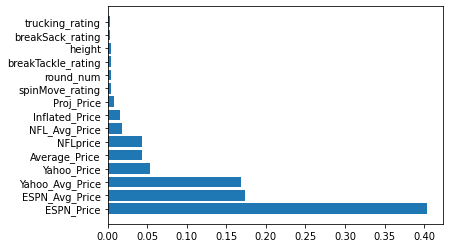

In [129]:
for idx, model in enumerate([DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor()]):
    # Decision Trees
    mse = []
    mae = []
    r2 = []
    for i in tqdm(range(100)):
        xtrain, xtest, ytrain, ytest = train_test_split(data.drop(["player_names", "bid_amounts"], axis=1), data["bid_amounts"], test_size=0.20)
        model.fit(xtrain, ytrain)
        predictions = model.predict(xtest)
        mse.append(mean_squared_error(predictions, ytest))
        mae.append(mean_absolute_error(predictions, ytest))
        r2.append(r2_score(predictions, ytest))
    print(str(model))
    print(f"MSE: {np.mean(mse)}")
    print(f"MAE: {np.mean(mae)}")
    print(f"R2: {np.mean(r2)}")
    if idx == 1: # Variable importance from RF model.
        plot_feature_importance(model, 15, data)